In [1]:
import numpy as np
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
import pandas as pd
import matplotlib.pyplot as plt
from seisLM.utils.project_path import gitdir
NUM_CLASSES = 4

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import (
  Conv1DShockClassifierLit, Wav2vec2ShockClassifierLit)


def get_seisLM_config():

  config_path = gitdir() + '/seisLM/configs/foreshock_aftershock/seisLM_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)

  config.model_args.num_classes = NUM_CLASSES
  return config


def get_conv1d_config():
  config_path = gitdir() + '/seisLM/configs/foreshock_aftershock/conv1d_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)
  config.model_args.num_classes = NUM_CLASSES
  return config



seisLM_config = get_seisLM_config()
conv1d_config = get_conv1d_config()

models = {}

models['seisLM'] = Wav2vec2ShockClassifierLit(
  model_config=seisLM_config.model_args,
  training_config=seisLM_config.trainer_args,
  ).model


models['cnn'] = Conv1DShockClassifierLit(
  model_config=conv1d_config.model_args,
  training_config=conv1d_config.trainer_args,
  ).model


In [3]:
loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=seisLM_config.model_args.num_classes,
  **seisLM_config.data_args
)

Seed set to 42
Seed set to 42


In [4]:
from sklearn.metrics import accuracy_score


for key, model in models.items():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = models[key].to(device)

  all_gt_class = []
  all_pred_class = []
  all_losses = []

  for X, y in loaders['test']:
    with torch.no_grad():
      logits = model(X.to(device)).cpu()
      pred_class = np.argmax(logits.numpy(), axis=1)
      loss = torch.nn.functional.cross_entropy(logits, y)

    all_gt_class.append(y)
    all_pred_class.append(pred_class)
    all_losses.append(loss)

  all_gt_class = np.concatenate(all_gt_class)
  all_pred_class = np.concatenate(all_pred_class)
  all_losses = np.array(all_losses)

  print(f'model {key} acc at init', accuracy_score(all_gt_class, all_pred_class))
  print(f'model {key} loss at init', np.mean(all_losses))

model seisLM acc at init 0.30870165745856354
model seisLM loss at init 1.3850363
model cnn acc at init 0.26657458563535913
model cnn loss at init 1.3845549


Text(0.5, 1.0, 'Wav2Vec2 hidden states')

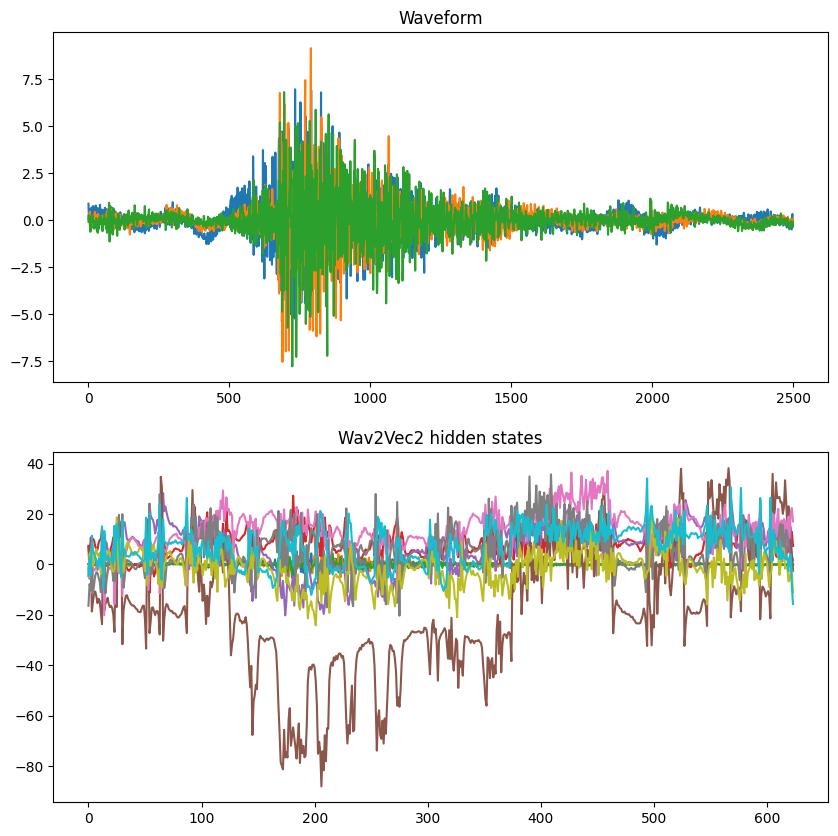

In [5]:
model = models['seisLM']

waveforms, _ = next(iter(loaders['test']))

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sample_idx = 0
num_channels_to_display = 10

with torch.no_grad():
  wav2vec2_outputs = model.get_wav2vec2_hidden_states(
    waveforms.to(device),
    concat_downsampled_input=seisLM_config.model_args.concat_downsampled_input
  )

axes[0].plot(waveforms[0].T)
axes[0].set_title('Waveform')

axes[1].plot(wav2vec2_outputs[0, :, :num_channels_to_display].detach().cpu().numpy())
axes[1].set_title('Wav2Vec2 hidden states')


In [6]:
wav2vec2_outputs[0, :, -num_channels_to_display:].shape

torch.Size([624, 10])

In [7]:
waveforms.shape

torch.Size([64, 3, 2500])

In [8]:
output

NameError: name 'output' is not defined